# Neural Modelling Assignment 3
Submission Group: Luca Kosina (6084778), Sascha Mühlinghaus (7075485)

### Part 1: TD Learning

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

In [103]:
# Function to create a reward array
def generate_reward_array(prob=0.95):
    # Parameters for the Gaussian distribution
    mean = 200
    std = 1
    x = np.arange(250)
    gaussian = (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std) ** 2)
    # Normalize the Gaussian to have an integral of 2
    gaussian *= 2 / np.sum(gaussian)

    if np.random.rand() < prob:  
        return gaussian
    else:  # Otherwise, return an array of zeros
        return np.zeros_like(gaussian)

def update_weights(alpha, stimuli, rewards, n_trials, prob=0.95, flag=True):
    V = np.zeros((len(stimuli))) # initialize value array for time points
    W = np.zeros(len(stimuli)) # initialize weight for each time point
    delta = np.zeros([len(n_trials), len(stimuli)]) # initialize 2D array for trial x time
    delta_v = np.zeros((len(stimuli))) # initialize array for delta v

    def value_helper(W, stimuli, t):
            # compute value for a given time point
            return (W[0:t] @ stimuli[t:0:-1])[0]
    
    for n in tqdm(range(len(n_trials))):
        # generate reward array
        if flag == True: 
            rewards = generate_reward_array(prob)
        # for every trial do the following
        for t in range(1, len(stimuli)):
            # compute delta_v for every time point
            V[t] = value_helper(W, stimuli, t)
            delta_v[t-1] = V[t] - V[t-1]
            # compute delta for every time step
            delta[n, t] = rewards[t] + delta_v[t]
            for tau in np.arange(t):
                # compute weight update 
                weight_update = W[tau] + alpha * delta[n, t] * stimuli[t-tau]
                # update every weight in the past
                W[tau] = weight_update

    return W, V, delta_v, delta

In [104]:
rewards = generate_reward_array(1)
np.sum(rewards)

2.0

In [105]:
def reproduce_plot(data_before, data_after, x, y, timesteps, delta_weight_after):
    labels = ['u', 'r', 'v', 'Δv', 'δ']

    # --- Panel A: 3D Surface Plot ---
    fig_a = plt.figure()
    ax1 = fig_a.add_subplot(111, projection='3d')
    ax1.plot_surface(x, y, delta_weight_after, antialiased=True,  color='k', alpha=1)
    ax1.set_xlabel('t')
    ax1.set_ylabel('trials')

    # Reposition the z-label
    ax1.set_zlabel("delta", labelpad=10)
    ax1.zaxis.label.set_position((0.05, 0.5))
    ax1.text2D(-0.1, 1.05, "A", transform=ax1.transAxes, fontsize=12, fontweight='bold')          

    # --- Panel B: Line Plots ---
    fig_b = plt.figure()  
    for i, (data_b, data_a, label) in enumerate(zip(data_before, data_after, labels)):
        # Before subplot: left column
        ax2 = fig_b.add_subplot(5, 2, 2 * i + 1)  # Corrected for left column
        ax2.plot(timesteps, data_b, color='black')
        ax2.set_ylabel(label, fontweight='bold')
        ax2.yaxis.label.set(rotation='horizontal', ha='right')
        ax2.set_ylim(-1, 2.2)
        ax2.grid(True, linestyle='--', alpha=0.6)
        if i == 0:
            ax2.set_title('before')
        
        # After subplot: right column
        ax3 = fig_b.add_subplot(5, 2, 2 * i + 2)  # Corrected for right column
        ax3.plot(timesteps, data_a, color='black')
        ax3.set_ylim(-1, 2.2)
        ax3.grid(True, linestyle='--', alpha=0.6)
        if i == 0:
            ax3.set_title('after')

    # Add panel label "B"
    fig_b.text(0.05, 0.95, "B", fontsize=12, fontweight='bold')
    
    # Show the figure for Panel B
    plt.tight_layout()
    plt.show()

In [106]:
t = 250 # number of time points
timesteps = np.arange(t) # time array
v_before = np.zeros(t) # value array
delta_v_before = np.zeros(t) # prediction error array

alpha = 0.1 # learning rate
u_stim = np.zeros((t, 1)) # stimuli array
u_stim[100] = 1 # stimulus at time point 100
# initialize the reward array
rewards = np.zeros(250)
# define the parameters for the Gaussian distribution
mean = 200
std = 1  
x = np.arange(250)
gaussian = (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std) ** 2)
# Normalize the Gaussian to have an integral of 2
gaussian *= 2 / np.sum(gaussian)
# generate reward array
rewards = gaussian
# delta of weight before learning
delta_weight_before = gaussian

### Stochastic Rewards and Learning Rates

100%|██████████| 1000/1000 [01:42<00:00,  9.80it/s]


Learning rate: 0.3


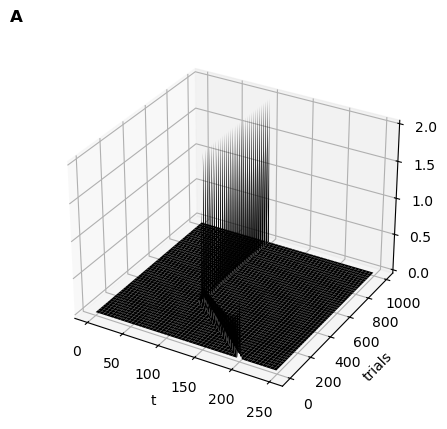

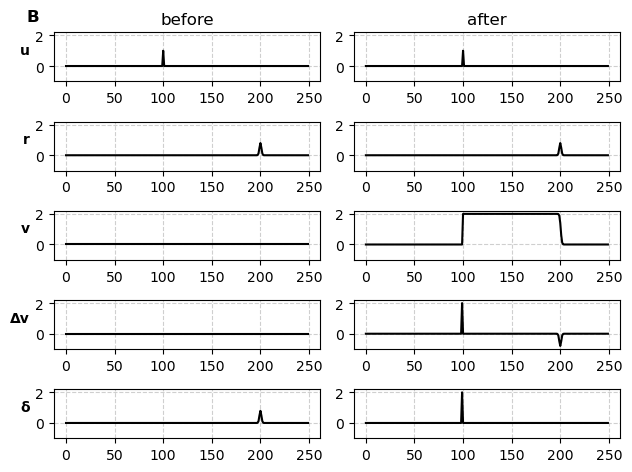

100%|██████████| 1000/1000 [01:42<00:00,  9.79it/s]


Learning rate: 0.2


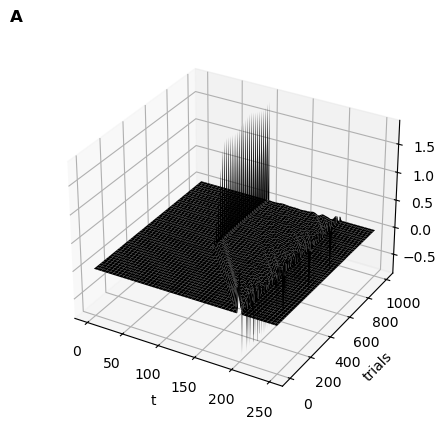

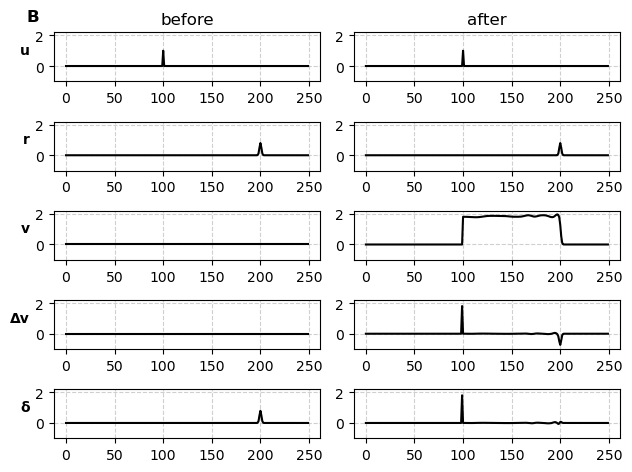

100%|██████████| 1000/1000 [01:40<00:00,  9.97it/s]


Learning rate: 0.1


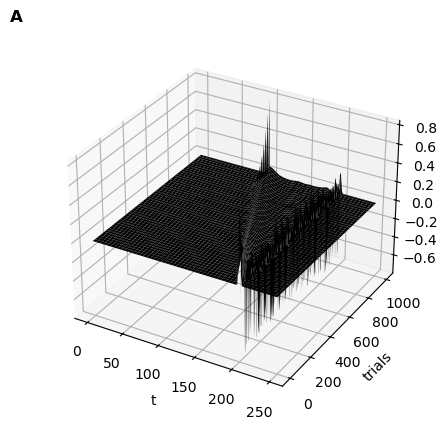

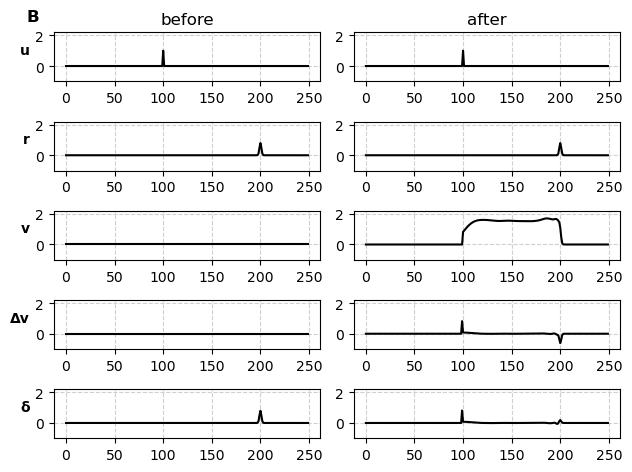

100%|██████████| 1000/1000 [01:44<00:00,  9.61it/s]


Learning rate: 0.01


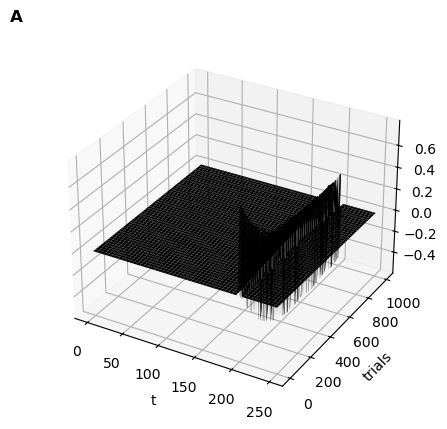

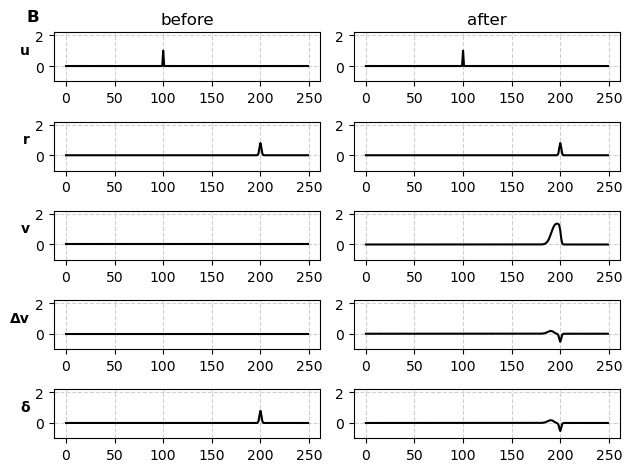

In [107]:
n_trials = np.arange(1000) # number of trials

# more uncertainty --> lower learning rate
alphas = [0.3, 0.2, 0.1, 0.01] 
stochastic_reward = [1, 0.9, 0.8, 0.7]

# call the temporal difference learning function
for i in range(len(alphas)):
    prob = stochastic_reward[i]
    alpha = alphas[i]
    W_after, V_after, delta_v_after, delta_weight_after = update_weights(alpha, u_stim, rewards, n_trials, prob)

    x, y = np.meshgrid(np.arange(delta_weight_after.shape[1]), np.arange(delta_weight_after.shape[0])) # Create a mesh grid for X and Y

    data_before = [u_stim, rewards, v_before, delta_v_before, delta_weight_before]
    data_after = [u_stim, rewards, V_after, delta_v_after, delta_weight_after[-1, :]]
    print(f"Learning rate: {alpha}")
    reproduce_plot(data_before, data_after, x, y, timesteps, delta_weight_after)

### Reward Timing 

100%|██████████| 500/500 [00:55<00:00,  9.08it/s]


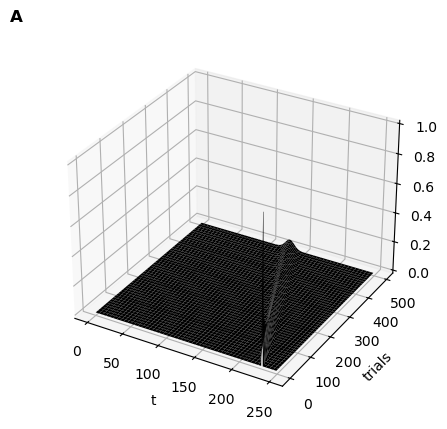

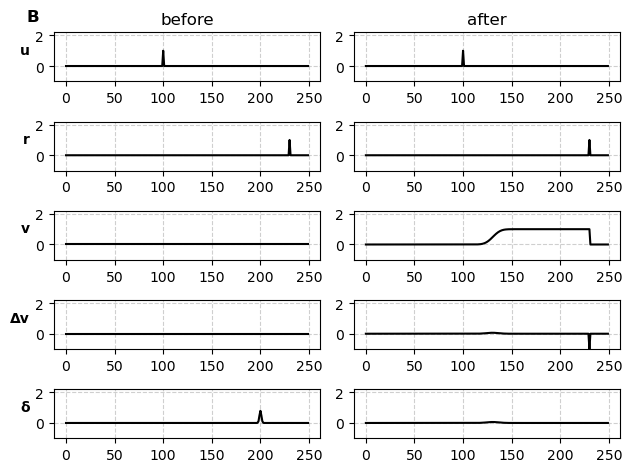

100%|██████████| 500/500 [00:54<00:00,  9.12it/s]


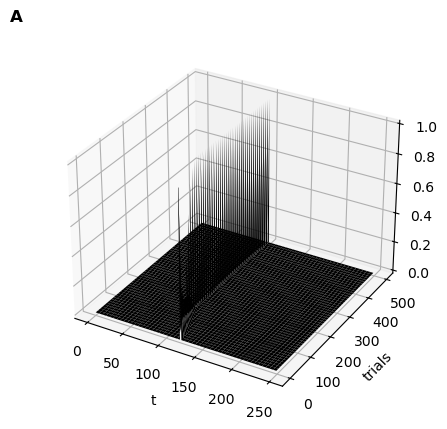

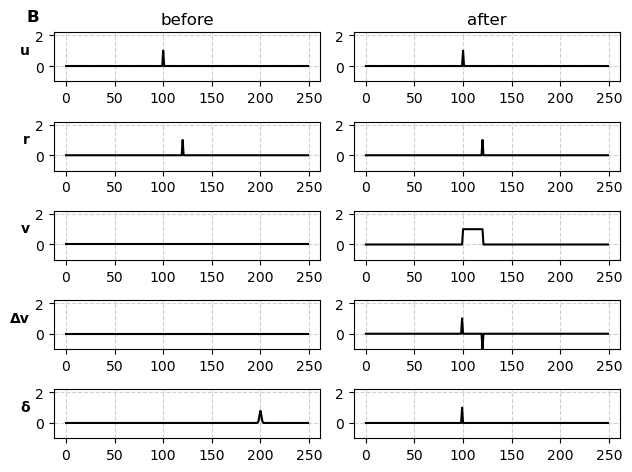

In [ ]:
n_trials = np.arange(500) # number of trials
rewards = np.zeros(250) # initialize the reward array
rewards[230] = 1 # reward at time point 230
alpha = 0.2 # learning rate

for i in range(2):
    W_after, V_after, delta_v_after, delta_weight_after = update_weights(alpha, u_stim, rewards, n_trials, prob, flag=False)
    x, y = np.meshgrid(np.arange(delta_weight_after.shape[1]), np.arange(delta_weight_after.shape[0])) # Create a mesh grid for X and Y
    data_before = [u_stim, rewards, v_before, delta_v_before, delta_weight_before]
    data_after = [u_stim, rewards, V_after, delta_v_after, delta_weight_after[-1, :]]
    reproduce_plot(data_before, data_after, x, y, timesteps, delta_weight_after)
    rewards = np.zeros(250) # initialize the reward array
    rewards[120] = 1 # reward at time point 120

## Interpretation of the Results

- **General Interpretation**: TD learning associates a reward with a stimulus even when there is a temporal difference between the two events. The expected reward ∆ propagates from the time of reward presentation to the earliest possible indication of the reward, typically the presentation of the stimulus.

- **Reward Timing**: A greater temporal difference between the reward and the stimulus lengthens the learning process to correctly predict the reward at the time of stimulus presentation.

- **Learning Rate**: The learning rate governs the speed of learning. In a noisy environment with stochastic rewards, a higher learning rate can result in more fluctuations in the updates.

- **Multiple Rewards**: When there are multiple rewards (e.g., normally distributed), the ∆-corridor in the plot widens, but eventually accumulates at the time of stimulus presentation.

- **Stochastic Rewards**: In environments where rewards are stochastic, the ∆-updates can exhibit significant variability, influenced by the learning rate.
